In [60]:
from xml.etree import ElementTree
from os import listdir
import numpy as np
from mrcnn.utils import Dataset
from matplotlib import pyplot
import imutils

class TestPiecesCarrierDataset(Dataset):
    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class('dataset', 1, 'test_piece')
        self.add_class('dataset', 2, 'carrier')
        
        images_dir = dataset_dir + '/pos/'
        annotations_dir = dataset_dir + '/annotations/'
        
        for filename in listdir(images_dir):
            image_id = filename[:-4]
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
            
            
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        print(path)
        boxes, w, h = self.parse_bounding_boxes(path)
        masks = np.zeros([w, h, len(boxes)], dtype='uint8')
        print("xmin", boxes[0][0], "ymin", boxes[0][1], "xmax", boxes[0][2],"ymax", boxes[0][3])
        class_ids = []
        print(len(boxes), " width ", w, " height ", h)
        for i in range(len(boxes)):
            box = boxes[i]
            # mirror image, for vertical displayed images like image_id = 0, horizontal(6) switch to the part commented out 
            row_s, row_e = box[0], box[2]
            #row_s, row_e = w - box[2], w - box[0]
            col_s, col_e = h - box[3], h - box[1]
            #col_s, col_e = box[1], box[3]
            print("rows", row_s, "rowe", row_e, "cols", col_s, "cole",  col_e)
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('test_piece'))
            class_ids.append(self.class_names.index('carrier'))
        return masks, np.asarray(class_ids, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
        
    def parse_bounding_boxes(self, src):
        tree = ElementTree.parse(src)
        root = tree.getroot()
        bdboxes = []
        
        for b in root.findall('.//bndbox'):
            xmin = int(b.find('xmin').text)
            ymin = int(b.find('ymin').text)
            xmax = int(b.find('xmax').text)
            ymax = int(b.find('ymax').text)
            xywh = [xmin, ymin, xmax, ymax]
            bdboxes.append(xywh)
        width = int(root.find('.//size/width').text) 
        height = int(root.find('.//size/height').text)
        return bdboxes, width, height


image:  (4000, 3000, 3)
img/annotations/Pos_00.xml
xmin 1 ymin 133 xmax 1433 ymax 2098
5  width  4000  height  3000
rows 1 rowe 1433 cols 902 cole 2867
rows 2383 rowe 2888 cols 1772 cole 2856
rows 2700 rowe 3255 cols 1795 cole 2972
rows 3024 rowe 3538 cols 1906 cole 2999
rows 3258 rowe 3981 cols 1815 cole 2999
masks:  (4000, 3000, 5)


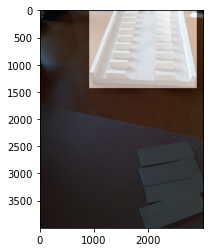

In [61]:
train_set = TestPiecesCarrierDataset()
train_set.load_dataset('img')
train_set.prepare()

image_id = 0
image = train_set.load_image(image_id)
print("image: " ,image.shape)

masks, class_ids = train_set.load_mask(image_id)
print("masks: ", masks.shape)

mask1 = masks[:, :, 0]
#mask2 = masks[:, :, 1]

pyplot.imshow(image)
pyplot.imshow(mask1, cmap='gray', alpha=0.6)
#pyplot.imshow(mask2, cmap='gray', alpha=0.3)
pyplot.show()

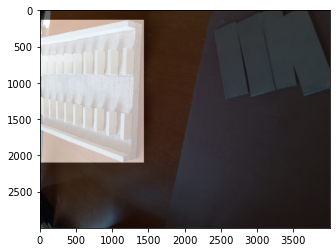

In [62]:
# rotate the image, helps sometimes, testing...-> maybe, merge with the one above later
rotated = imutils.rotate_bound(image, 270)
#print("rotated", rotated.shape)

rotated_mask1 = imutils.rotate_bound(mask1, 270)
#rotated_mask2 = imutils.rotate_bound(mask2, 270)
#print("rotated_mask1: ", rotated_mask1.shape)

pyplot.imshow(rotated)
pyplot.imshow(rotated_mask1, cmap='gray', alpha=0.6)
#pyplot.imshow(rotated_mask2, cmap='gray', alpha=0.3)
pyplot.show()

#TODO: maybe rotate images before mask is adapted